จากใน ep ก่อน 

# 0. Magic Commands


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
import torch.nn.init as init

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

# 2. ข้อมูล

ใช้ชุดข้อมูล Dataset [MNIST](https://www.bualabs.com/archives/2215/what-is-mnist/) ตัวเลขอารบิคเขียนด้วยลายมือ

In [6]:
## Small Dataset for quick test
path = untar_data(URLs.MNIST_SAMPLE)

## Full Dataset
# path = untar_data(URLs.MNIST)
path

PosixPath('/root/.fastai/data/mnist_sample')

# 3. เตรียมข้อมูล



1. สำหรับข้อมูลประเภทตัวเลข เราไม่สามารถ flip ซ้าย ขวา ขึ้น ลง ได้ จะทำให้ผิดความหมายไป จึงต้องใช้ get_transforms(do_flip=False)
2. เคสนี้ label คือชื่อ Folder ที่บรรจุไฟล์อยู่ เราสามารถ ใช้ ImageDataBunch.from_folder ได้เลย
3. num_workers คือ จำนวน CPU Core ที่ต้องการใช้

In [0]:
batchsize = 64
max_lr = 3e-2
wd = 1e-1
np.random.seed(0)
transform = get_transforms(do_flip=False)

databunch = ImageDataBunch.from_folder(path, train='training', valid_pct=0.2, size=28, 
                                       ds_tfms=transform, bs=batchsize, num_workers=8).normalize()

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 10 x 10 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

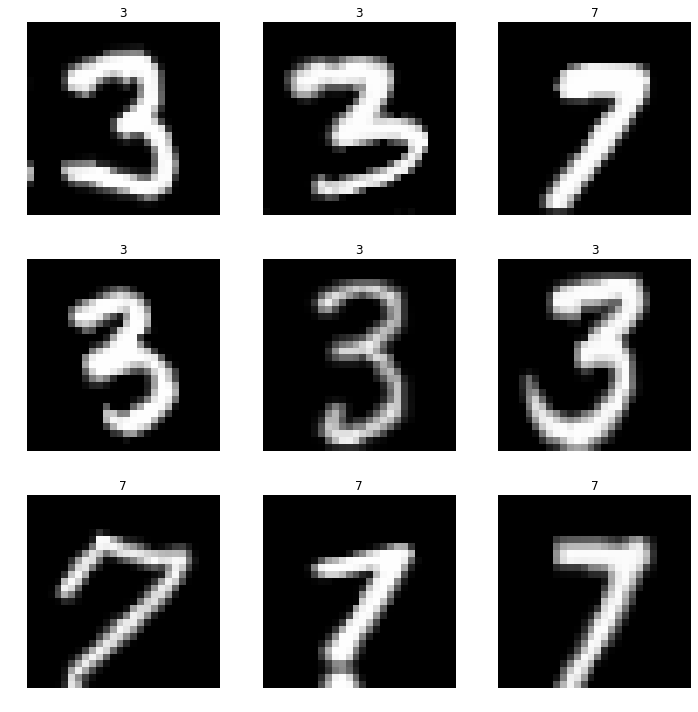

In [8]:
databunch.show_batch(rows=3, figsize=(10, 10))

ดู label ตัวเลขทั้งหมด หรือ class ทั้งหมด ที่มีใน Dataset

In [9]:
databunch.classes

['3', '7']

# 4. สร้างโมเดล

เราจะสร้างโมเดล Deep Convolutional Neural Network ที่มี 4 ConvLayer และใช้ GeneralRelu ดังด้านล่าง

In [0]:
def get_cnn_model(data, **kwargs):
    return nn.Sequential(
        nn.Conv2d(  3,  8, 5, padding=2, stride=2), GeneralRelu(**kwargs), #14
        nn.Conv2d(  8, 16, 3, padding=1, stride=2), GeneralRelu(**kwargs), # 7
        nn.Conv2d( 16, 32, 3, padding=1, stride=2), GeneralRelu(**kwargs), # 4
        nn.Conv2d( 32, 32, 3, padding=1, stride=2), GeneralRelu(**kwargs), # 2
        nn.AdaptiveAvgPool2d(1), 
        Lambda(flatten), 
        nn.Linear(32, data.c)
    )

class GeneralRelu(nn.Module): 
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

# def mnist_resize(x): return x.view(-1, 1, 28, 28)
def flatten(x): return x.view(x.shape[0], -1)    

def init_cnn(m, uniform=False, bias=True):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Conv2d):
            f(l.weight, a=0.1)
            if bias: l.bias.data.zero_()

สร้างโมเดล และ Initialize ด้วย Kaiming Normal

In [0]:
model = get_cnn_model(databunch, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)

In [0]:
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): GeneralRelu()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): GeneralRelu()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): GeneralRelu()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): GeneralRelu()
  (8): AdaptiveAvgPool2d(output_size=1)
  (9): Lambda()
  (10): Linear(in_features=32, out_features=10, bias=True)
)

In [0]:
def children(m): list(m.children())

class Hook():
    # m = module, f = function
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats 
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    # Tensor.histc(bins, min, max)
    hists.append(outp.data.cpu().histc(80, -10, 10))

class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx): 
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx) == len(self) # boolean mask
            return [o for m, o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10: res = res[:-1] + '...]'
        return res
        
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    
    def remove(self):
        for h in self: h.remove()  

In [0]:
learner = Learner(databunch, model, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล


พล็อตกราฟ Mean และ Variance ของ 10 Iteration แรก และ กราฟ Mean และ Variance ของตลอดการเทรน

epoch,train_loss,valid_loss,accuracy,time
0,0.180632,0.114160,0.964857,01:42


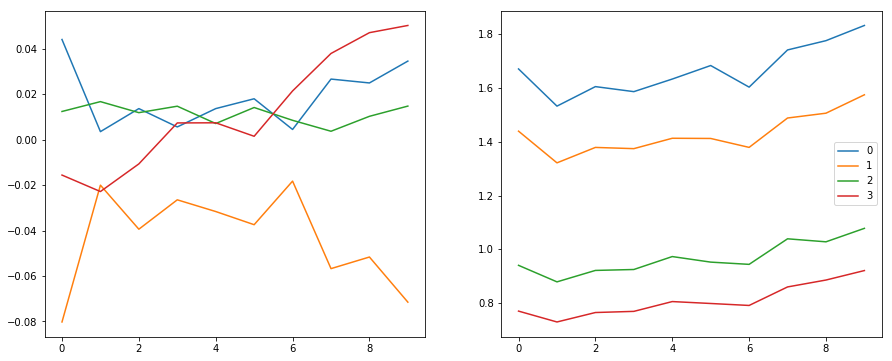

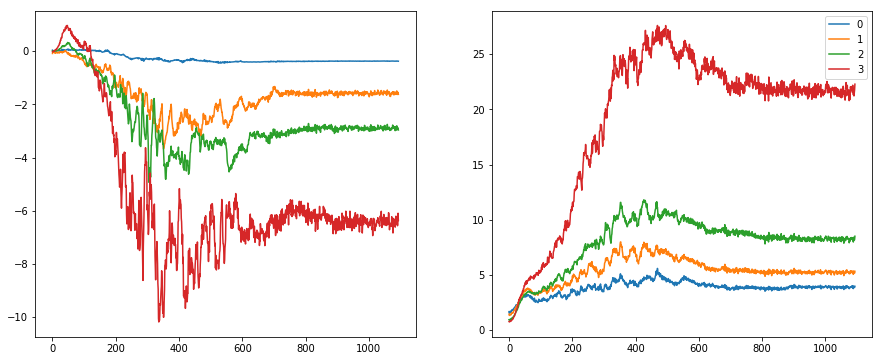

In [0]:
with Hooks(learner.model, append_stats) as hooks: 

    learner.fit_one_cycle(1, max_lr=max_lr, wd=wd)

    # Plot first 10 iterations.
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
    for h in hooks[[0, 2, 4, 6]]:
        # ms = means, ss = stds, _ = histogram
        ms, ss, _ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(4))

    # Plot all
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
    for h in hooks[[0, 2, 4, 6]]:
        ms, ss, _ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(4))

# 6. Intepret

ดู Histogram ของ Activation Map ว่าอยู่ไหนช่วงไหนกันบ้าง ทั้งแต่ -10 ถึง 10 ตรงกลางคือ 0

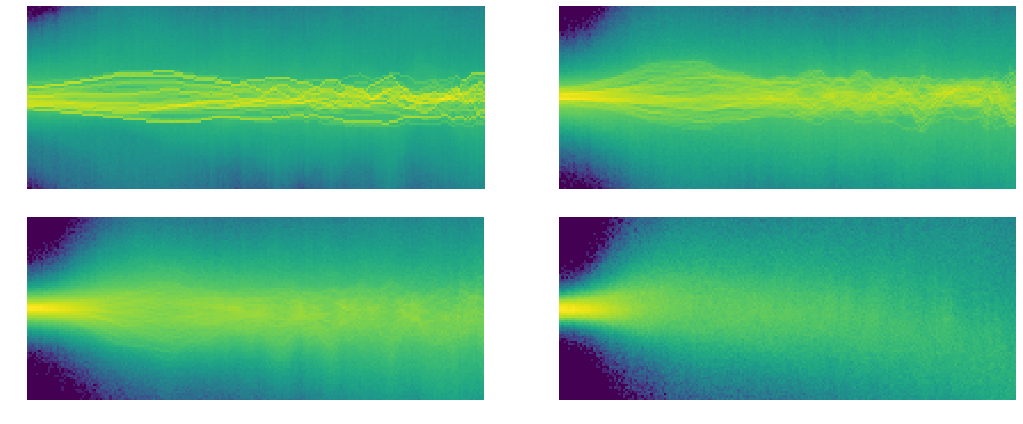

In [0]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()[:,:200]

fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[[0, 2, 4, 6]]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

พล็อตกราฟสัดส่วนของ Activation Map ที่มีค่าน้อย ต่อ Activation Map ทั้งหมด

In [0]:
def get_min(h):
    # stats = mean, std, histogram, stats[2] = hists
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[38:42].sum(0)/h1.sum(0)

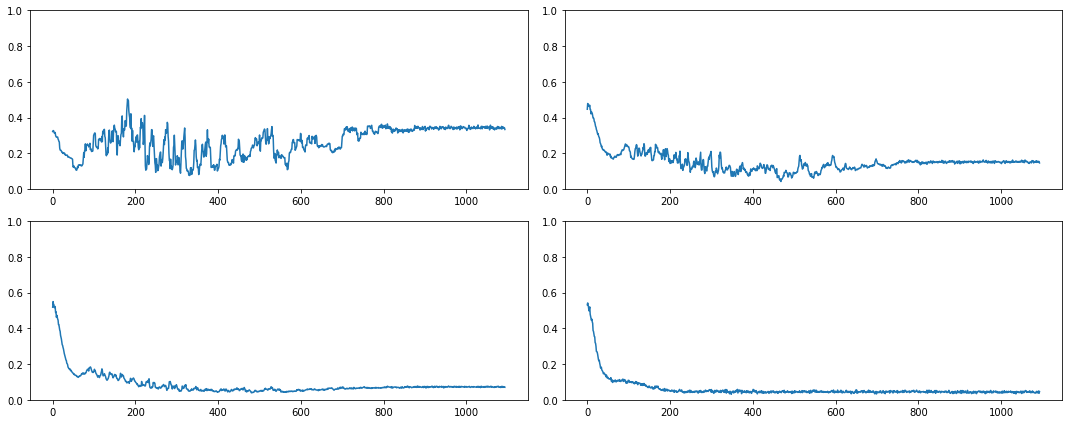

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[[0, 2, 4, 6]]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

# 4/2. Model with BatchNorm